## Notes and resources

https://quantum.cloud.ibm.com/ = dashboard for the IBM Quantum Cloud


Before starting this tutorial, ensure that you have the following installed:

* Qiskit SDK 1.0 or later with visualization support (`pip install `)
* Qiskit Runtime 0.22 or later (`pip install `)


In [1]:
# autoreload
%load_ext autoreload
%autoreload 2


In [2]:
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService


## Setup


In [3]:


service = QiskitRuntimeService(
    channel='ibm_quantum_platform',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/00676e59ecdd4175be3cc729886ac91a:3d11824a-45a9-46fa-ac02-c700f961f10c::'
)
job = service.job('d1bb9uuc0o9c73aolemg')
job_result = job.result()



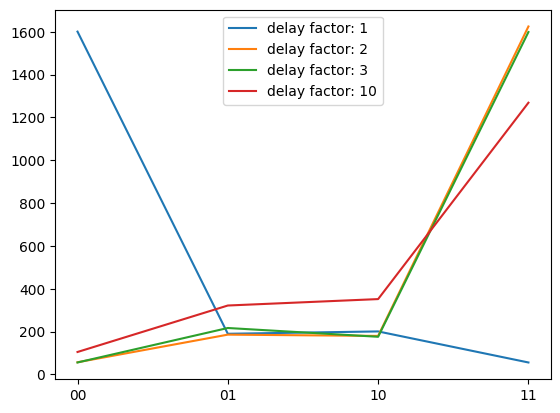

In [7]:
delay_factors = [1, 2, 3, 10]
xvals = ['00', '01', '10', '11']
fig, ax = plt.subplots()
for i in range(len(job_result)):
    delay_factor = delay_factors[i]
    counts = job_result[i].data.round_0_link_bit_0.get_counts()
    ax.plot(xvals, [counts.get(x, 0) for x in xvals], label=f"delay factor: {delay_factor}")
ax.legend()
# ax.semilogy()
plt.show()

In [5]:
def get_job_result(job_id):
    service = QiskitRuntimeService(
        channel='ibm_quantum_platform',
        instance='crn:v1:bluemix:public:quantum-computing:us-east:a/00676e59ecdd4175be3cc729886ac91a:3d11824a-45a9-46fa-ac02-c700f961f10c::'
    )
    job = service.job(job_id)
    return job.result()



### June 24 run

First pass doing an $n=3,T=1$ repetition code

In [10]:

n3_t1_train_job_id = 'd1dmmq5qbivc73eacsbg'
n3_t1_test_job_id = 'd1dmmqaq8ogc73erbb1g'

n3_t1_train_result = get_job_result(n3_t1_train_job_id)
n3_t1_test_result = get_job_result(n3_t1_test_job_id)


In [13]:
n3_t1_train_result[0]

SamplerPubResult(data=DataBin(round_0_link_bit_0=BitArray(<shape=(), num_shots=2048, num_bits=2>), code_bit_0=BitArray(<shape=(), num_shots=2048, num_bits=3>)), metadata={'circuit_metadata': {}})

In [17]:
n3_t1_test_result[1].data.code_bit_0.get_counts()

{'111': 1372,
 '101': 329,
 '100': 24,
 '011': 162,
 '001': 32,
 '110': 117,
 '010': 10,
 '000': 2}

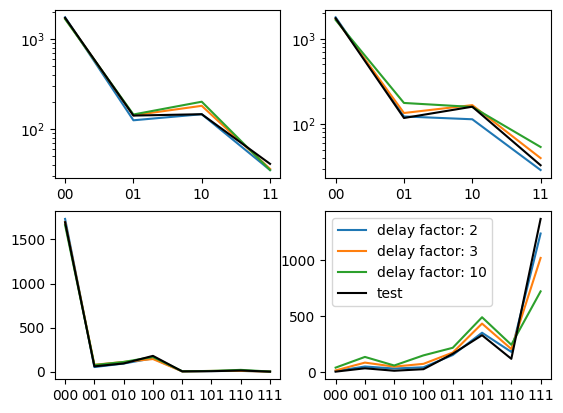

In [23]:
delay_factors = [2, 3, 10]

# plot the distribution of syndromes 
bit2_vals = ['00', '01', '10', '11']
bit3_vals = ['000', '001', '010',  '100', '011', '101', '110', '111']
fig, axes = plt.subplots(2, 2)
for i in range(len(delay_factors)):
    # these are the synrdome counts for the first round of each experiment
    logical_0_results = n3_t1_train_result[2*i]
    logical_1_results = n3_t1_train_result[2*i+1]
    l0_counts = logical_0_results.data.round_0_link_bit_0.get_counts()
    l1_counts = logical_1_results.data.round_0_link_bit_0.get_counts()
    # these are the final bitstring for the experiment
    l0_final = logical_0_results.data.code_bit_0.get_counts()
    l1_final = logical_1_results.data.code_bit_0.get_counts()
    axes[0,0].plot(bit2_vals, [l0_counts.get(x, 0) for x in bit2_vals], label=f"delay factor: {delay_factors[i]}")
    axes[0,1].plot(bit2_vals, [l1_counts.get(x, 0) for x in bit2_vals], label=f"delay factor: {delay_factors[i]}")

    axes[1,0].plot(bit3_vals, [l0_final.get(x, 0) for x in bit3_vals], label=f"delay factor: {delay_factors[i]}")
    axes[1,1].plot(bit3_vals, [l1_final.get(x, 0) for x in bit3_vals], label=f"delay factor: {delay_factors[i]}")

# also plot test distributions
test_logical_0_results = n3_t1_test_result[0]
test_logical_1_results = n3_t1_test_result[1]
axes[0,0].plot(bit2_vals, [test_logical_0_results.data.round_0_link_bit_0.get_counts().get(x, 0) for x in bit2_vals], label="test", c='k')
axes[0,1].plot(bit2_vals, [test_logical_1_results.data.round_0_link_bit_0.get_counts().get(x, 0) for x in bit2_vals], label="test", c='k')
axes[1,0].plot(bit3_vals, [test_logical_0_results.data.code_bit_0.get_counts().get(x, 0) for x in bit3_vals], label="test", c='k')
axes[1,1].plot(bit3_vals, [test_logical_1_results.data.code_bit_0.get_counts().get(x, 0) for x in bit3_vals], label="test", c='k')

axes[0,0].set_yscale('log')
axes[0,1].set_yscale('log')
axes[1,1].legend()

In [ ]:
service = QiskitRuntimeService(
    channel='ibm_quantum_platform',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/00676e59ecdd4175be3cc729886ac91a:3d11824a-45a9-46fa-ac02-c700f961f10c::'
)
job = service.job('d1a6lqemm8oc73a07l50')
job_result = job.result()

In [3]:
# Qiskit imports
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer.primitives import SamplerV2 as AerSampler

# tutorial at https://github.com/Qiskit/textbook/blob/main/notebooks/quantum-hardware/error-correction-repetition-code.ipynb
from mldec.hardware.topological_codes.circuits import RepetitionCode
from mldec.hardware.topological_codes.fitters import GraphDecoder, lookuptable_decoding

# circuit wrappers and optimizers
from mldec.hardware.topological_codes.wrappers import insert_idle_delays
from mldec.hardware.topological_codes.noise import get_noise

### Setting up simulations and backwards compatibility of decoders.

In [128]:
# # build a lookup table (careful, this is really slow.)
# table_results = get_raw_results(code, noise_model=noise_model, shots=10000)
# print(table_results)
# P = lookuptable_decoding(raw_results, table_results)
# print('P =', P)

In [9]:
results = code.process_results(raw_results)

# processed_results format: [initial logical obs], [final logical obs], [t=1 detectors], ..., [t=T detectors]
for log in ['0', '1']:
    print(f'\nLogical {log}:')
    print('raw results       ', {string:raw_results[log][string] for string in raw_results[log] if raw_results[log][string]>=25 })
    print('processed results ', {string:results[log][string] for string in results[log] if results[log][string]>=25 })


Logical 0:
raw results        {'00000 0000 0000': 498, '00010 0000 0000': 41, '00000 0010 0010': 51, '00000 0000 1000': 50, '00000 0000 0100': 42, '00000 0100 0100': 53, '00001 0000 0000': 35, '01000 0000 0000': 41, '00000 1000 1000': 46, '00000 0000 0001': 41, '00000 0000 0010': 48, '10000 0000 0000': 35, '00100 0000 0000': 41, '00000 0001 0001': 47}
processed results  {'0 0  0000 0000 0000': 498, '0 0  0000 0000 0011': 41, '0 0  0010 0010 0000': 51, '0 0  1000 0000 1000': 50, '0 0  0100 0000 0100': 42, '0 0  0100 0100 0000': 53, '0 1  0000 0000 0001': 35, '0 0  0000 0000 1100': 41, '0 0  1000 1000 0000': 46, '0 0  0001 0000 0001': 41, '0 0  0010 0000 0010': 48, '1 0  0000 0000 1000': 35, '0 0  0000 0000 0110': 41, '0 0  0001 0001 0000': 47}

Logical 1:
raw results        {'11111 0000 0001': 47, '11111 1000 1000': 47, '11111 0000 0000': 446, '11111 0010 0010': 36, '10111 0000 0000': 31, '01111 0000 0000': 48, '11111 0001 0001': 57, '11111 0000 0100': 40, '11101 0000 0000': 33, '11111

### Set up hardware job submission

NOTES:
 - I think it makes sense to do the delays with two specs: (1) delay by a fraction $\beta$ of the following gate's length, (2) delay the physical ``compiled'' gates, not the logical ones. Aha! This makes even more sense with the virtual Z's, which I'd forgotten about.
  - think about: the delays are staggering the circuit in some ways, especially since they're done post-transpilation. maybe its cleaner to do this with barriers around the measurements? These are the dominant delays after all..

In [10]:
service = QiskitRuntimeService()
backend = service.least_busy(
    simulator=False, operational=True, min_num_qubits=5
)
print("backend: ", backend)

backend:  <IBMBackend('ibm_torino')>


In [96]:
n = 3
T = 1
code = RepetitionCode(n, T)
qc = code.circuit['0']
sampler = Sampler(mode=backend)

In [11]:
from qiskit.transpiler import Layout
# assign qubits to specific physical qubits in the pattern code-link-code-link-code
def make_layout(qc, target_qubits):
    qregs_links = qc.qregs[0]
    qregs_code = qc.qregs[1]
    assert len(target_qubits) == len(qregs_code) + len(qregs_links)

    mapping_dict = {}
    code_targets = target_qubits[::2]
    link_targets = target_qubits[1::2]
    mapping_dict.update(zip(code_targets, qregs_code))
    mapping_dict.update(zip(link_targets, qregs_links))
    layout = Layout(input_dict=mapping_dict)
    return layout


In [98]:
target_qubits = [4, 16, 23, 24, 25]
layout = make_layout(qc, target_qubits)

# restrict the layout to be exactly an 2n+1 line on the device
pm = generate_preset_pass_manager(optimization_level=1, backend=backend, layout_method='trivial', routing_method='none', initial_layout=layout)


In [86]:
# DEBUG
n = 3
T = 1
code = RepetitionCode(n, T)
sampler = Sampler(mode=backend)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend, layout_method='trivial', routing_method='none', initial_layout=layout)


In [99]:
### RUN THE JOB ###
# create a list of the circuit with a different wait time insertion
delay_factors = [1, 2, 3, 10]
all_circuits = []
isa_circuit = pm.run(code.circuit['1'])
for delay_factor in delay_factors:
    isa_circuit_delayed = insert_idle_delays(isa_circuit, delay_factor=delay_factor, backend=backend)
    all_circuits.append(isa_circuit_delayed)

job = sampler.run(all_circuits, shots=2048)
job_id = job.job_id()
print("delay factors: ", delay_factors, "job_id: ", job_id)

delay factors:  [1, 2, 3, 10] job_id:  d1bb9uuc0o9c73aolemg


In [ ]:
# current running jobs: wait times 0, 100, ..., 1000 with a logical '1' prepared.
# To get counts for a particular pub result, use
#
# pub_result = job_result[<idx>].data.<classical register>.get_counts()
#
# where <idx> is the index of the pub and <classical register> is the name of the classical register.
# You can use circuit.cregs to find the name of the classical registers.

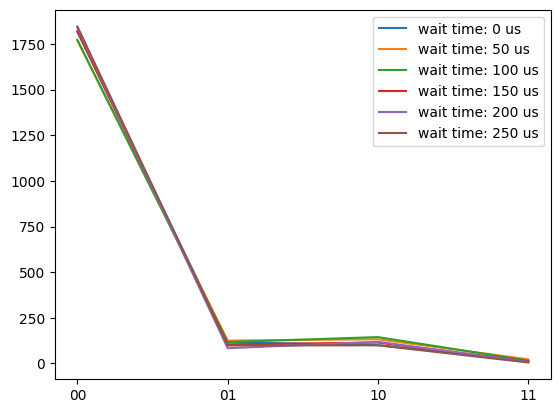

In [78]:
xvals = ['00', '01', '10', '11']
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for i in range(len(job_result)):
    us = us_wait_times[i]
    counts = job_result[i].data.round_0_link_bit_0.get_counts()
    ax.plot(xvals, [counts.get(x, 0) for x in xvals], label=f"wait time: {us} us")
ax.legend()
# ax.semilogy()
plt.show()


In [25]:
# get job results for first test runs
service = QiskitRuntimeService(
    channel='ibm_quantum_platform',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/00676e59ecdd4175be3cc729886ac91a:3d11824a-45a9-46fa-ac02-c700f961f10c::'
)

# without wait gates:
job = service.job('d19m0c04nhtc73abin60')
job_result = job.result()
# with wait gates:
job_idle = service.job('d19m0c96rndc73faasig')
job_idle_result = job_idle.result()


In [26]:
print(job_result[0].data.round_0_link_bit_0.get_counts())
print(job_idle_result[0].data.round_0_link_bit_0.get_counts())



{'00': 974, '10': 21, '01': 5}
{'00': 926, '01': 47, '10': 23, '11': 4}


In [ ]:
pub_result = job_result[0].data.<classical register>.get_counts()

# To get counts for a particular pub result, use
#
# pub_result = job_result[<idx>].data.<classical register>.get_counts()
#
# where <idx> is the index of the pub and <classical register> is the name of the classical register.
# You can use circuit.cregs to find the name of the classical registers.

In [146]:
job_idle.status()
result = job_idle.result()

'QUEUED'

In [ ]:

isa_circuit = pm.run(qc)
isa_operators_list = [op.apply_layout(isa_circuit.layout) for op in operators]



# print(qc.draw(output='text'))

# qc_idle = 
# print(qc_idle.draw(output='text'))

In [ ]:
def get_raw_results(code,noise_model=None, shots=10):

    noisy_sampler = Sampler(
        options=dict(backend_options=dict(noise_model=noise_model))
    )

    circuits = code.get_circuit_list()
    job = noisy_sampler.run(circuits, shots=shots)
    results = job.result()
    # convert the distinct measurement results into a single string, to be compatible with the topolotical_codes decoders.
    out = {}
    for i, result in enumerate(results):
        raw_results = {}
        data = result.data
        all_meas_all_rounds = [getattr(data, f"round_{j}_link_bit_0").get_bitstrings() for j in range(T)]
        final_code_meas = getattr(data, f"code_bit_0").get_bitstrings()
        for k in range(shots):
            combined = final_code_meas[k] + " " + " ".join([all_meas_all_rounds[j][k] for j in range(T)])
            raw_results[combined] = raw_results.get(combined, 0) + 1
        out[str(i)] = raw_results
        
    return out

In [63]:
noise_model = get_noise(0.05, 0.05)
raw_results = get_raw_results(code, noise_model=noise_model)
for i, result in enumerate(raw_results):
    data = result.data
    print(f"logical |{i}>")
    for j in range(T): # each round has one set of parity measurements
        print(f"round {j}: ", getattr(data, f"round_{j}_link_bit_0").get_counts())
    print("final measurements")
    print(getattr(data, f"code_bit_0").get_counts())
    print()

logical |0>
round 0:  {'00': 8, '01': 1, '11': 1}
round 1:  {'11': 4, '00': 6}
final measurements
{'110': 2, '000': 7, '010': 1}

logical |1>
round 0:  {'10': 3, '00': 7}
round 1:  {'10': 3, '00': 4, '01': 3}
final measurements
{'111': 5, '011': 1, '101': 3, '000': 1}

